In [1]:
%load_ext rpy2.ipython

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


In [2]:
%%R
library(Seurat)
library(dplyr)
library(SeuratDisk)
library(Matrix)
library(Signac)
library(slingshot)
library(ggplot2)

options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


R[write to console]: Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

R[write to console]: Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

R[write to console]: Loading required package: princurve

R[write to console]: Loading required package: TrajectoryUtils

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: 'matrixStats'


R[writ

Fontconfig warning: ignoring UTF-8: not a valid region tag


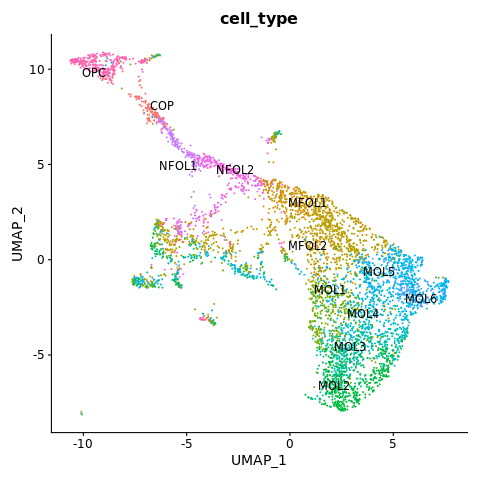

In [3]:
%%R
marques.seurat  <- readRDS(file='/data/proj/GCB_MB/single-cell-CUT-Tag/nbiotech_paper/analysis/results/marques_RNA/clustering/01.clustering.Rds')
marques.seurat <- marques.seurat[,marques.seurat$cell_type != 'PPR']
DimPlot(marques.seurat,group.by='cell_type',label=TRUE,repel=TRUE) + NoLegend()

In [4]:
%%R
brain.H3K27ac     <- readRDS(file='/data/proj/GCB_MB/bcd_CT/single-cell/results/multimodal_data/single_modality/H3K27ac/seurat/peaks/Seurat_object_clustered_renamed.Rds')
brain.H3K27ac.OLG <- brain.H3K27ac[,brain.H3K27ac$idents_short %in% c('OPC','MOL')]

rm(brain.H3K27ac)



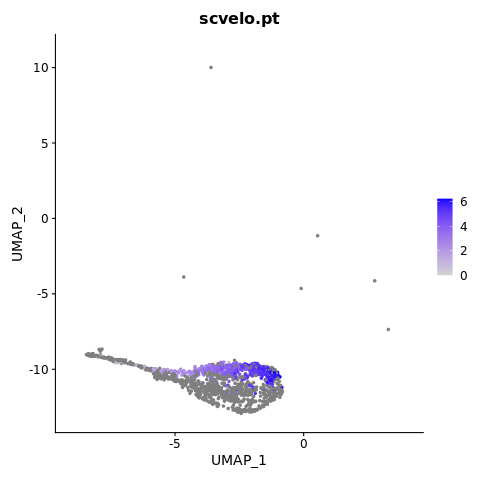

In [5]:
%%R
scvelo.metadata <- read.csv(file='/data/proj/GCB_MB/bcd_CT/single-cell/results/velocity/obs.csv',row.names=1)
brain.H3K27ac.OLG <- AddMetaData(brain.H3K27ac.OLG,metadata = setNames(scvelo.metadata[,'pt'],rownames(scvelo.metadata)), col.name = 'scvelo.pt')

DimPlot(brain.H3K27ac.OLG,group.by = 'idents_short',label=TRUE,repel=TRUE)
FeaturePlot(brain.H3K27ac.OLG,features = 'scvelo.pt')

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



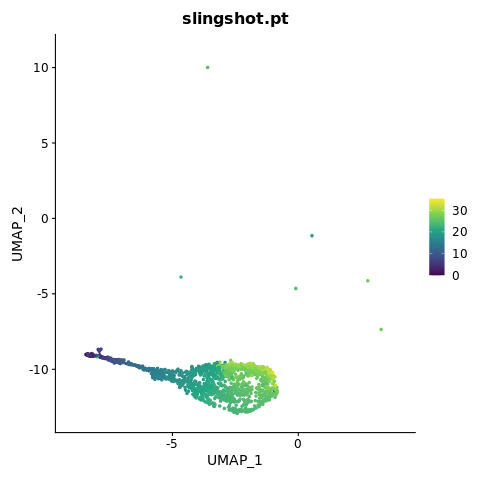

In [6]:
%%R
#de novo slingshot PT 
sshot <- slingshot(Embeddings(brain.H3K27ac.OLG,'lsi')[,1:40],clusterLabels = brain.H3K27ac.OLG$idents_short)
pt    <- slingPseudotime(sshot)
pt1   <- setNames(as.numeric(pt[,1]), rownames(pt))
brain.H3K27ac.OLG  <- AddMetaData(brain.H3K27ac.OLG,metadata = pt1 ,col.name='slingshot.pt')
FeaturePlot(brain.H3K27ac.OLG,'slingshot.pt') + scale_color_viridis_c()



In [7]:
%%R
DefaultAssay(brain.H3K27ac.OLG) <- 'GA'
DefaultAssay(marques.seurat)    <- 'RNA'
common.features <- intersect(rownames(brain.H3K27ac.OLG), rownames(marques.seurat))

transfer.anchors <- FindTransferAnchors(
  reference = marques.seurat,
  query = brain.H3K27ac.OLG,
  reduction = 'cca',
  query.assay = 'GA',reference.assay = 'RNA',
  features = common.features
)


R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 6003 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 1458 anchors



In [8]:
%%R
genes.use   <- VariableFeatures(marques.seurat)
refdata     <- GetAssayData(marques.seurat, assay = "RNA", slot = "data")[genes.use, ]

imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = brain.H3K27ac.OLG[["lsi"]],dims = 2:50)


R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[writ

In [9]:
%%R
brain.H3K27ac.OLG[['RNA']] <- imputation
coembed <- merge(x =marques.seurat , y = brain.H3K27ac.OLG)

coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30)


R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: 11:14:51 UMAP embedding parameters a = 0.9922 b = 1.112

R[write to console]: 11:14:51 Read 6372 rows and found 

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



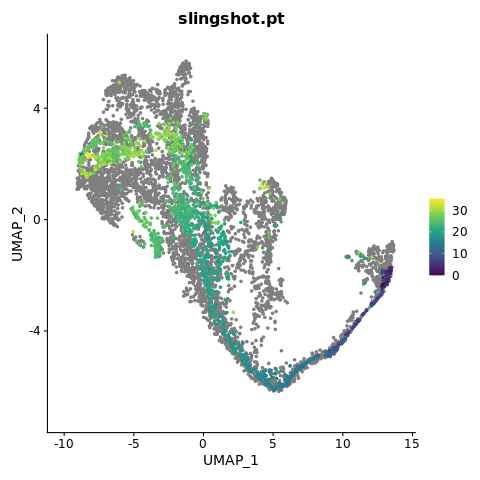

In [10]:
%%R
DimPlot(coembed,group.by='idents_short',label=TRUE) + NoLegend()
DimPlot(coembed,group.by='cell_type',label=TRUE) + NoLegend()

FeaturePlot(coembed,'scvelo.pt',pt.size=1) + scale_color_viridis_c()
FeaturePlot(coembed,'slingshot.pt',pt.size=1) + scale_color_viridis_c()


In [19]:
%%R
p1 <- FeaturePlot(coembed[,coembed$orig.ident == 'bcdCT' & !is.na(coembed$scvelo.pt)],'scvelo.pt',pt.size=1) + scale_color_viridis_c() + ggtitle('')
p2 <- DimPlot(coembed[,coembed$orig.ident == 'SeuratProject' ],pt.size=0.2,label=TRUE,repel=TRUE,) + NoLegend()

p1+p2

ggsave(plot=p1+p2,filename = '/data/proj/GCB_MB/bcd_CT/single-cell/results/figures/revision/scvelo_pseudotime_scRNA_integration.pdf',width=7,height=7)

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



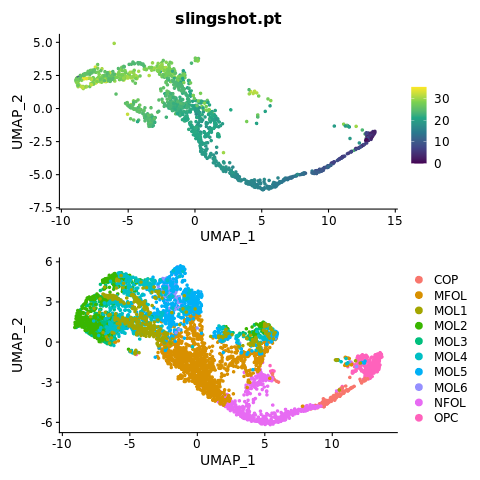

In [20]:
%%R
p1 <- FeaturePlot(coembed[,coembed$orig.ident == 'bcdCT'],'slingshot.pt',pt.size=1) + scale_color_viridis_c()
p2 <- DimPlot(coembed[,coembed$orig.ident == 'SeuratProject' ],pt.size=1)

p1+p2

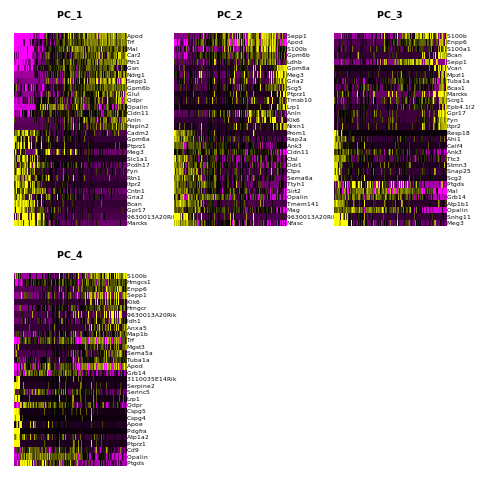

In [23]:
%%R
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)
DimHeatmap(coembed,dims=1:4)

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



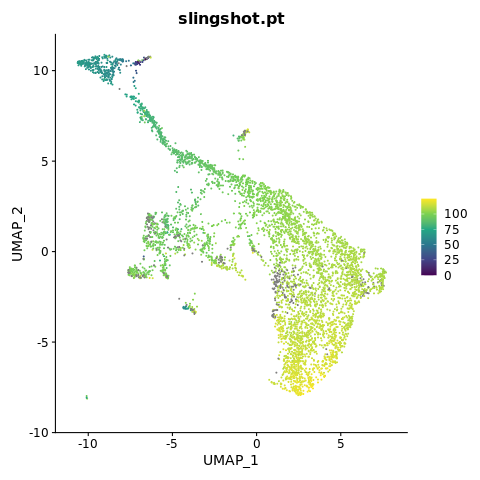

In [24]:
%%R
#de novo slingshot PT 
sshot           <- slingshot(Embeddings(marques.seurat,'pca')[,1:40],clusterLabels = marques.seurat$cell_type)
pt              <- slingPseudotime(sshot)
pt1             <- setNames(as.numeric(pt[,1]), rownames(pt))
marques.seurat  <- AddMetaData(marques.seurat,metadata = pt1 ,col.name='slingshot.pt')

FeaturePlot(marques.seurat,'slingshot.pt') + scale_color_viridis_c()



R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



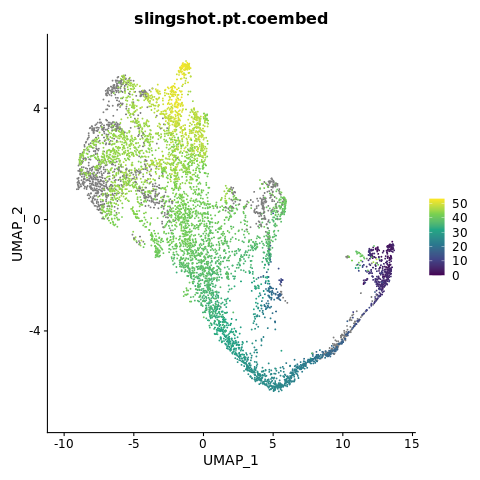

In [25]:
%%R
#de novo slingshot PT on coembed 

coembed         <- AddMetaData(coembed,metadata = c(marques.seurat$cell_type, brain.H3K27ac.OLG$seurat_clusters),col.name='cell_type_coembed')
sshot           <- slingshot(Embeddings(coembed,'pca')[,1:40],clusterLabels = coembed$cell_type_coembed)
pt              <- slingPseudotime(sshot)
pt1             <- setNames(as.numeric(pt[,1]), rownames(pt))
coembed         <- AddMetaData(coembed,metadata = pt1 ,col.name='slingshot.pt.coembed')


FeaturePlot(coembed,'slingshot.pt.coembed') + scale_color_viridis_c()

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



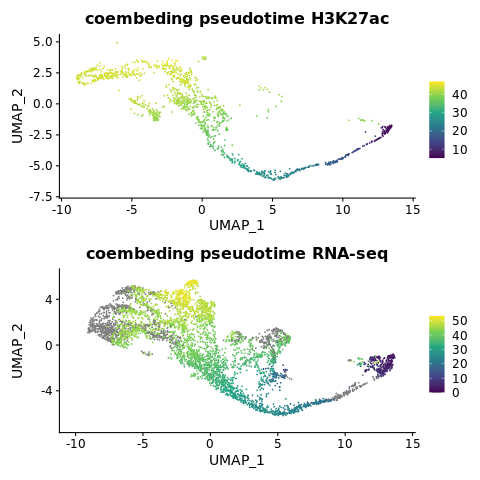

In [26]:
%%R
DimPlot(coembed,group.by='cell_type_coembed')

p1 <- FeaturePlot(coembed[,coembed$orig.ident == 'bcdCT'],'slingshot.pt.coembed',pt.size=0.2) + scale_color_viridis_c() + ggtitle('coembeding pseudotime H3K27ac')
p2 <- FeaturePlot(coembed[,coembed$orig.ident == 'SeuratProject'],'slingshot.pt.coembed',pt.size=0.2) + scale_color_viridis_c() + ggtitle('coembeding pseudotime RNA-seq')
p1+p2



In [28]:
%%R
coembed <- AddMetaData(coembed, as.character(Hmisc::cut2(coembed$slingshot.pt.coembed,g=10)),col.name = 'pt.group')

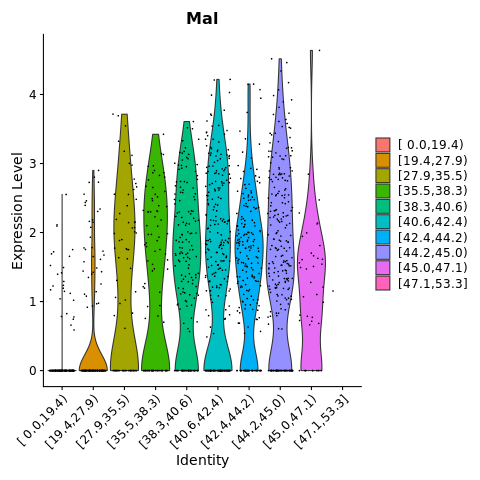

In [29]:
%%R
brain.H3K27ac.OLG <- AddMetaData(brain.H3K27ac.OLG,metadata=coembed$pt.group,col.name='pt.group')
marques.seurat    <- AddMetaData(marques.seurat, metadata = coembed$pt.group, col.name= 'pt.group')


VlnPlot(brain.H3K27ac.OLG,group.by='pt.group','Mal')

In [31]:
%%R
library(dplyr)
marques.markers <- read.csv2(file='/data/proj/GCB_MB/single-cell-CUT-Tag/nbiotech_paper/analysis/results/marques_RNA/clustering/markers.csv')
markers.top <- marques.markers %>% group_by(cluster) %>% top_n(n = 20,wt=avg_logFC)
markers.top <- unique(markers.top$gene)

In [32]:
%%R
markers.top <- markers.top[markers.top %in% rownames(marques.seurat)]
markers.top <- markers.top[markers.top %in% rownames(brain.H3K27ac.OLG)]


cor.ls <- lapply(markers.top,function(x){
# lapply('Mal',function(x){
    g1 <- cbind(GetAssayData(marques.seurat,slot = 'data')[x,],marques.seurat$pt.group)
    g2 <- cbind(GetAssayData(brain.H3K27ac.OLG,slot = 'data')[x,],brain.H3K27ac.OLG$pt.group)
    g1 <- g1[!is.na(g1[,2]),]
    g2 <- g2[!is.na(g2[,2]),]
    g1 <- aggregate(as.numeric(g1[,1]), by=list(g1[,2]), FUN=mean)
    g2 <- aggregate(as.numeric(g2[,1]), by=list(g2[,2]), FUN=mean)
    g <- merge(g1,g2,by='Group.1')
#    print(g)
    cor(g[,2],g[,3])
})



       Ptprz1          Jph4           Dcn       Zdhhc20          Sox6 
    0.9615252     0.9442716     0.9433722     0.9374912     0.9338761 
        Nrxn1         Itpr2          Il33           Tnr           Ntm 
    0.9314875     0.9211156     0.9179265     0.9152838     0.9140015 
       Marcks          Lrp1          Sdc3          Anln 3110035E14Rik 
    0.9106426     0.9094471     0.8926355     0.8900949     0.8799428 
        Cyr61       Ppfibp1         Ttyh1         Sox11         Efr3b 
    0.8746291     0.8732900     0.8614154     0.8457429     0.8377650 


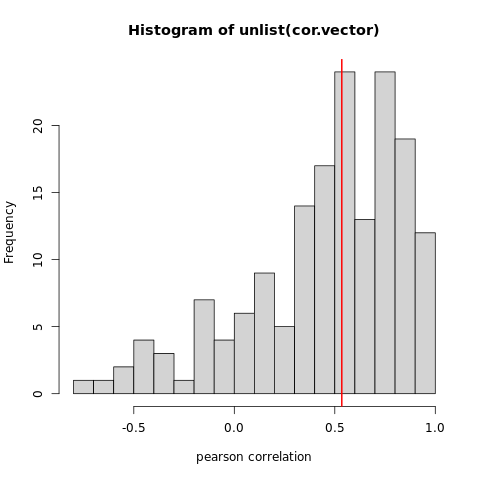

In [33]:
%%R
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)

cor.vector <- unlist(cor.ls)
names(cor.vector) <- markers.top

median(cor.vector)
hist(unlist(cor.vector),breaks=20,xlab='pearson correlation')
abline(v=median(unlist(cor.vector)),col='red',lwd=2)

head(sort(cor.vector,decreasing=TRUE),20)

In [45]:
%%R
x <- 'Itpr2'

g1 <- cbind(GetAssayData(marques.seurat,slot = 'data')[x,],marques.seurat$pt.group)
g2 <- cbind(GetAssayData(brain.H3K27ac.OLG,slot = 'data')[x,],brain.H3K27ac.OLG$pt.group)
g1 <- g1[!is.na(g1[,2]),]
g2 <- g2[!is.na(g2[,2]),]
g1 <- aggregate(as.numeric(g1[,1]), by=list(g1[,2]), FUN=mean)
g2 <- aggregate(as.numeric(g2[,1]), by=list(g2[,2]), FUN=mean)
g <- merge(g1,g2,by='Group.1')
head(g)
ggplot(data=g) + geom_point(aes(x=x.x,y=x.y,col=Group.1)) + theme_bw() + scale_color_viridis_d() + xlab('gene expression') + ylab('H3K27ac') + ggtitle(x)
ggsave(filename='/data/proj/GCB_MB/bcd_CT/single-cell/results/figures/revision/Itpr2_H3K27ac_RNA_seq_phase_plot.pdf',width=5,height=5)

In [46]:
%%R
x <- 'Mal'

g1 <- cbind(GetAssayData(marques.seurat,slot = 'data')[x,],marques.seurat$pt.group)
g2 <- cbind(GetAssayData(brain.H3K27ac.OLG,slot = 'data')[x,],brain.H3K27ac.OLG$pt.group)
g1 <- g1[!is.na(g1[,2]),]
g2 <- g2[!is.na(g2[,2]),]
g1 <- aggregate(as.numeric(g1[,1]), by=list(g1[,2]), FUN=mean)
g2 <- aggregate(as.numeric(g2[,1]), by=list(g2[,2]), FUN=mean)
g <- merge(g1,g2,by='Group.1')
head(g)
ggplot(data=g) + geom_point(aes(x=x.x,y=x.y,col=Group.1)) + theme_bw() + scale_color_viridis_d()+ xlab('gene expression') + ylab('H3K27ac') + ggtitle(x)
ggsave(filename='/data/proj/GCB_MB/bcd_CT/single-cell/results/figures/revision/Mal_H3K27ac_RNA_seq_phase_plot.pdf',width=5,height=5)

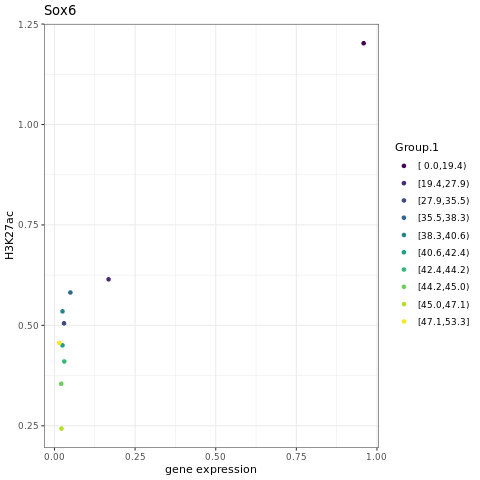

In [36]:
%%R
x <- 'Sox6'

g1 <- cbind(GetAssayData(marques.seurat,slot = 'data')[x,],marques.seurat$pt.group)
g2 <- cbind(GetAssayData(brain.H3K27ac.OLG,slot = 'data')[x,],brain.H3K27ac.OLG$pt.group)
g1 <- g1[!is.na(g1[,2]),]
g2 <- g2[!is.na(g2[,2]),]
g1 <- aggregate(as.numeric(g1[,1]), by=list(g1[,2]), FUN=mean)
g2 <- aggregate(as.numeric(g2[,1]), by=list(g2[,2]), FUN=mean)
g <- merge(g1,g2,by='Group.1')
head(g)
ggplot(data=g) + geom_point(aes(x=x.x,y=x.y,col=Group.1)) + theme_bw() + scale_color_viridis_d()+ xlab('gene expression') + ylab('H3K27ac') + ggtitle(x)

In [39]:
%%R
velocity_genes <- read.csv(file='/data/proj/GCB_MB/bcd_CT/single-cell/results/multiple_modalities/ATAC_H3K27ac_H3K27me3/seurat_multimodal/peaks/scvelo/ATAC_H3K27ac/top_genes_per_cluster.csv',row.names=1)
velocity_genes <- unique(c(velocity_genes[,1], velocity_genes[,2]))

length(velocity_genes)
velocity_genes <- velocity_genes[velocity_genes %in% rownames(marques.seurat)]
velocity_genes <- velocity_genes[velocity_genes %in% rownames(brain.H3K27ac.OLG)]
length(velocity_genes)

cor.ls.velo <- lapply(velocity_genes,function(x){
# lapply('Mal',function(x){
    g1 <- cbind(GetAssayData(marques.seurat,slot = 'data')[x,],marques.seurat$pt.group)
    g2 <- cbind(GetAssayData(brain.H3K27ac.OLG,slot = 'data')[x,],brain.H3K27ac.OLG$pt.group)
    g1 <- g1[!is.na(g1[,2]),]
    g2 <- g2[!is.na(g2[,2]),]
    g1 <- aggregate(as.numeric(g1[,1]), by=list(g1[,2]), FUN=mean)
    g2 <- aggregate(as.numeric(g2[,1]), by=list(g2[,2]), FUN=mean)
    g <- merge(g1,g2,by='Group.1')
#    print(g)
    cor(g[,2],g[,3])
})



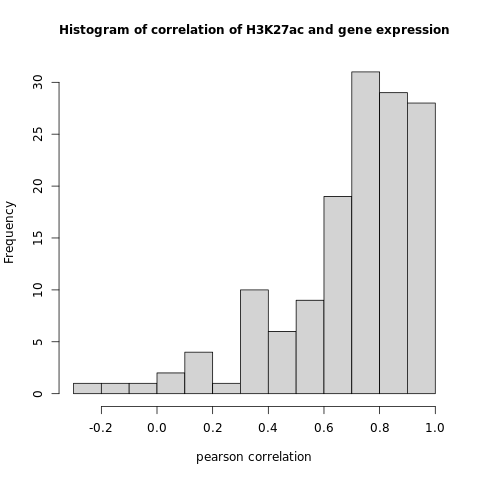

In [44]:
%%R
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)

cor.vector <- unlist(cor.ls.velo)
names(cor.vector) <- velocity_genes

median(cor.vector)

pdf('/data/proj/GCB_MB/bcd_CT/single-cell/results/figures/revision/histogram_H3K27ac_scRNA-seq_correlation.pdf',width=4,height=4)
hist(unlist(cor.vector),breaks=10,xlab='pearson correlation', main='Histogram of correlation of H3K27ac and gene expression',cex.main=1)
abline(v=median(unlist(cor.vector)),col='red',lwd=2)
dev.off()

head(sort(cor.vector,decreasing=TRUE),50)
hist(unlist(cor.vector),breaks=10,xlab='pearson correlation', main='Histogram of correlation of H3K27ac and gene expression',cex.main=1)


In [41]:
%%R
median(head(sort(cor.vector,decreasing=TRUE),length(cor.vector)*0.5))

[1] 0.882614
